Synthetic Interferometry - This requires some extra steps in the ray tracing to include information on the phase and electric field values

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, '../../src/')

import simulator.config as config
config.jax_init()

import simulator.beam as beam_initialiser
import simulator.domain as d
import simulator.propagator as p
import processing.diagnostics as diag

import importlib
importlib.reload(beam_initialiser)
importlib.reload(d)
importlib.reload(p)
importlib.reload(diag)

Setting top level path for imports: /home/administrator/Work/UROP_ICL_Internship/synthPy/src

Disabling python multi-threading...
Initialising jax...

Default jax backend: cpu
Available devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9), CpuDevice(id=10), CpuDevice(id=11), CpuDevice(id=12), CpuDevice(id=13), CpuDevice(id=14), CpuDevice(id=15)]


/home/administrator/Programs/anaconda3/envs/testing/lib/python3.12/site-packages/equinox/_config.py:15: UserWarning: The environment variable `EQX_ON_ERROR=breakpoint` is currently set. Note that this should only be used for debugging, as it slows down runtime speed.
  warnings.warn(


<module 'processing.diagnostics' from '/home/administrator/Work/UROP_ICL_Internship/synthPy/src/processing/diagnostics.py'>

In [2]:
# define some extent, the domain should be distributed as +extent to -extent, does not need to be cubic
extent_x = 5e-3
extent_y = 5e-3
extent_z = 10e-3

n_cells = 128

probing_extent = extent_z
probing_direction = 'z'

lengths = 2 * np.array([extent_x, extent_y, extent_z])

domain = d.ScalarDomain(lengths, n_cells, ne_type = "test_exponential_cos", inv_brems = False, phaseshift = True)

Predicted size in memory of domain: 8.0 MB

Free memory: 5.457401275634766 GB
83886080.0
80.0 MB
80.0 MB
Est. memory limit: 80.0 MB --> inc. +100% variance margin.

Coordinates have shape of (128, 128, 128) --> no padding required.

Generating test exponential decay periodic -e field...


In [3]:
lwl = 1064e-9

Np = 2e5
divergence = 5e-5
beam_size = extent_x
ne_extent = probing_extent
beam_type = 'circular'

beam_definition = beam_initialiser.Beam(
    Np, beam_size, divergence, ne_extent,
    probing_direction = probing_direction,
    wavelength = lwl,
    beam_type = "circular"
)

In [4]:
# No need to change the domain (now that code has been seperated out in restructure)



# load some external pvti

# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)

# or load a test distribution



# initialise beam



# solve ray trace
rf, Jf, duration = p.solve(beam_definition.s0, domain, probing_extent, return_E = True, lwl = lwl)


Size in memory of initial rays: 135.80322265625 MB
 --> Np = 200000

No need to generate any sections of the domain, batching not utilised.
 --> tracing a depth of 0.01 mm's to the target depth of 0.01 mm's

Running device: cpu, with: 16 cores.
NamedSharding(mesh=Mesh('rows': 16, axis_types=(Auto,)), spec=PartitionSpec('rows', None), memory_kind=unpinned_host)

jax compilation of solver took: 0.0006084442138671875 seconds

/home/administrator/Programs/anaconda3/envs/testing/lib/python3.12/site-packages/equinox/_errors.py:171: UserWarning: Ignoring intermediate `jax.jit` decorator, to work around JAX issue #16732, as `EQX_ON_ERROR=breakpoint` is set.
  warnings.warn(



Completed ray trace in 13.203001 seconds.

Parallelised output has resulting 3D matrix of form: [batch_count, (save_points_per_region - 1) * ScalarDomain.region_count, 9]: (200000, 2, 9)
 - 2 to account for the start and end results (typical, can be greater if set)
 - 9 containing the 3 position and velocity components, amplitude, phase and polarisation
 - If batch_count is lower than expected, this is likely due to jax's forced integer batch sharding requirement over cpu cores.

We slice the end result and transpose into the form: (4, 200000) to work with later code.


In [5]:
# adjust number of fringes and tilt in degrees from the vertical exis
n_fringes = 10
deg = 10


200000 rays received, 130857 incident on the first lens.
 --> 34.600002 % of rays wasted!


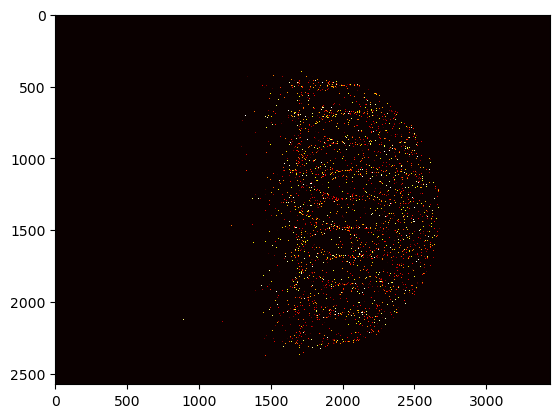

In [6]:
pattern = diag.Interferometry(lwl, rf, Jf)
pattern.interfere_ref_beam(n_fringes, deg)
pattern.two_lens_solve()

pattern.interferogram()

plt.imshow(pattern.H, cmap = 'hot', interpolation = 'nearest')


200000 rays received, 130857 incident on the first lens.
 --> 34.600002 % of rays wasted!


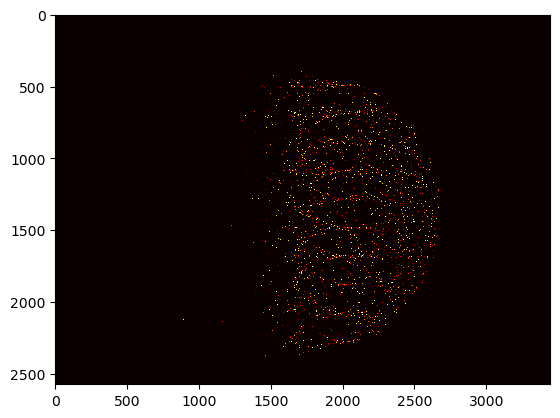

In [7]:
interferometrer = diag.Interferometry(lwl, rf, Jf)
interferometrer.two_lens_solve()
interferometrer.interferogram(bin_scale = 1, clear_mem = False) #use interferogram instead of histogram

#get interferogram histogram with sh.H
plt.imshow(interferometrer.H, cmap = 'hot', interpolation = 'nearest')

In [8]:
refractometer = diag.Refractometry(lwl, rf, Jf)
refractometer.incoherent_solve()
refractometer.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))


200000 rays received, 130857 incident on the first lens.
 --> 34.600002 % of rays wasted!


AttributeError: 'Refractometry' object has no attribute 'interferogram'


200000 rays received, 131029 incident on the first lens.
 --> 34.5 % of rays wasted!

rf size expected: [131029. 131029.]
rf after clearing nan's: [122626. 122626.]


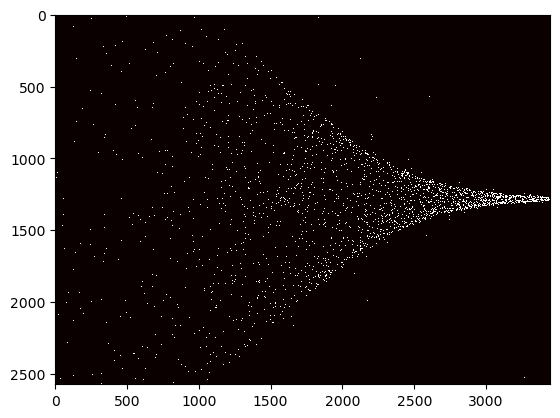

In [ ]:
refractometer = diag.Refractometry(lwl, rf, Jf)
refractometer.coherent_solve()
refractometer.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))


200000 rays received, 131029 incident on the first lens.
 --> 34.5 % of rays wasted!

rf size expected: [131029. 131029.]
rf after clearing nan's: [131029. 131029.]


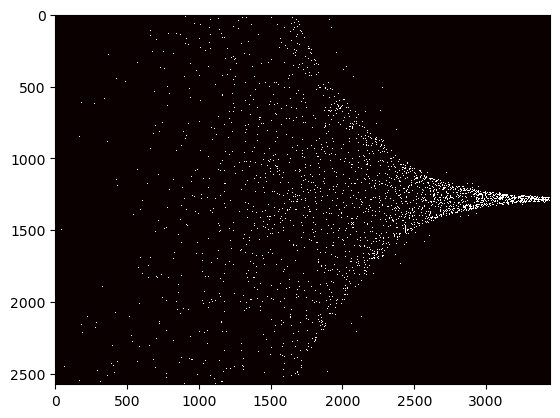

In [ ]:
refractometer = diag.Refractometry(lwl, rf, Jf)
refractometer.coherent_solve_alt()
refractometer.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))